# IMC BRCA Data Compartment Classification using UTAG
Data from Jackson et Al. 2019

## Loading Libraries

In [2]:
cd ~/imc-graph/utag

C:\Users\jkim0\imc-graph\utag


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from IPython.display import display
from utag.segmentation import UTAG, evaluate_performance
from utag.utils import celltype_connectivity, domain_connectivity
from utag.vizualize import (
    add_scale_box_to_fig,
    add_spatial_image,
    adj2chord,
    draw_network,
)

sc.settings.set_figure_params(dpi=150, fontsize=8)
sc.settings.verbosity = 0

Warning, OS could not be easily identified. Using default dir ~/.utag to store resources but that might not work!


## Preprocessing

In [3]:
adata = sc.read("data/BRCA_preprocessed.h5ad")

var_order = [
    "Fibronectin(Nd142)",
    "SMA(Nd148)",
    "Vimentin(Sm149)",
    "CD68(Nd146)",
    "CD3(Sm152)",
    "CD44(Gd160)",
    "CD45(Dy162)",
    "Cytokeratin 7(Yb174)",
    "EpCAM(Dy161)",
    "Cytokeratin 19(Nd143)",
    "pan Cytokeratin(Lu175)",
    "Cytokeratin 8/18(Nd144)",
    "GATA3(Dy163)",
    "Rabbit IgG H L(Gd156)",
    "Progesterone Receptor A/B'(Gd158)",
    "mTOR(Yb173)",
    "c-erbB-2 - Her2(Eu151)",
    "Histone H3(In113)",
    "S6(Er170)",
    "Twist(Nd145)",
    "CD31(Yb172)",
    "vWF(Yb172)",
    "CD20(Dy164)",
    "Carbonic Anhydrase IX(Er166)",
    "p53(Tb159)",
    "EGFR(Tm169)",
    "c-Myc(Nd150)",
    "Slug(Gd155)",
    "Ki-67(Er168)",
    "Keratin 14 (KRT14)(Sm147)",
    "Cytokeratin 5(Pr141)",
    "DNA1(Ir191)",
]

adata = adata[adata.obs["sample"].str.startswith("BaselTMA")]

adata = adata[:, var_order]
z_score_cap = 3.0
batch_key = "PID"

sc.pp.scale(adata, max_value=z_score_cap)
adata.X[adata.X < -z_score_cap] = -z_score_cap

pm = pd.read_csv("data/BRCA_Basel_PatientMetadata.csv")
pm["Slide"] = pm["FileName_FullStack"].str.strip("_full.tiff")

adata.obs = adata.obs.merge(pm, on="Slide")

sc.pp.pca(adata)

sc.pp.combat(adata, key=batch_key)
sc.pp.scale(adata, max_value=z_score_cap)
adata.X[adata.X < -z_score_cap] = -z_score_cap

C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\anndata\_core\anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Slide' as categorical
C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

# Running UTAG Algorithm

In [ ]:
%%time
results = UTAG(
    adata,
    slide_key="Slide",
    max_dist=20,
    normalization_mode="l1_norm",
    apply_clustering=True,
    clustering_method="leiden",
    parc_pcs=10,
)

## Preliminary Data

In [77]:
results = sc.read("data/BRCA_UTAG_expression_parc_clustered.h5ad")

In [ ]:
import seaborn as sns

cm = sns.clustermap(
    adata.to_df().corr(),
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
)
var_order = adata.var.iloc[cm.dendrogram_col.reordered_ind].index

In [14]:
results

AnnData object with n_obs × n_vars = 800427 × 32
    obs: 'area_x', 'perimeter', 'major_axis_length', 'eccentricity', 'solidity', 'X_centroid', 'Y_centroid', 'Slide', 'sample', 'PID', 'core', 'grade', 'tumor_size', 'gender', 'PTNM_M', 'age', 'Patientstatus', 'treatment', 'PTNM_T', 'DiseaseStage', 'PTNM_N', 'AllSamplesSVSp4.Array', 'TMALocation', 'TMAxlocation', 'yLocation', 'diseasestatus', 'TMABlocklabel', 'UBTMAlocation', '%tumorcells', '%normalepithelialcells', '%stroma', '%inflammatorycells', 'Yearofsamplecollection', 'PrimarySite', 'histology', 'PTNM_Radicality', 'Lymphaticinvasion', 'Venousinvasion', 'ERStatus', 'PRStatus', 'HER2Status', 'Pre-surgeryTx', 'Post-surgeryTx', 'Tag', 'Ptdiagnosis', 'DFSmonth', 'OSmonth', 'Comment', 'ER+DuctalCa', 'TripleNegDuctal', 'hormonesensitive', 'Post_surgeryTx', 'hormoneresistantaftersenstive', 'Fulvestran', 'microinvasion', 'I_plus_neg', 'SN', 'MIC', 'Count_Cells', 'FileName_FullStack', 'Height_FullStack', 'Width_FullStack', 'area_y', 'sum_are

In [4]:
var_order = [
    "Fibronectin(Nd142)",
    "SMA(Nd148)",
    "Vimentin(Sm149)",
    "CD68(Nd146)",
    "CD3(Sm152)",
    "CD44(Gd160)",
    "CD45(Dy162)",
    "Cytokeratin 7(Yb174)",
    "EpCAM(Dy161)",
    "Cytokeratin 19(Nd143)",
    "pan Cytokeratin(Lu175)",
    "Cytokeratin 8/18(Nd144)",
    "GATA3(Dy163)",
    "Rabbit IgG H L(Gd156)",
    "Progesterone Receptor A/B'(Gd158)",
    "mTOR(Yb173)",
    "c-erbB-2 - Her2(Eu151)",
    "Histone H3(In113)",
    "S6(Er170)",
    "Twist(Nd145)",
    "CD31(Yb172)",
    "vWF(Yb172)",
    "CD20(Dy164)",
    "Carbonic Anhydrase IX(Er166)",
    "p53(Tb159)",
    "EGFR(Tm169)",
    "c-Myc(Nd150)",
    "Slug(Gd155)",
    "Ki-67(Er168)",
    "Keratin 14 (KRT14)(Sm147)",
    "Cytokeratin 5(Pr141)",
    "DNA1(Ir191)",
]

sc.settings.set_figure_params(dpi=150, fontsize=10)
sc.pl.matrixplot(
    results,
    var_names=var_order,
    groupby="UTAG Label_parc_0.1",
    dendrogram=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    show=False,
    save="BRCA_matrixplot",
)

NameError: name 'results' is not defined

# Determining Resolution of Interest and Relabelling Clusters

In [ ]:
import seaborn as sns

label1 = "UTAG Label"
label2 = "UTAG Label_parc_0.1"
color1 = label1 + "_colors"
color2 = label2 + "_colors"
# import
# results.uns['GATDU Label_colors'] = sns.color_palette().as_hex()
adata.uns[color1] = np.array(
    sns.color_palette("tab10").as_hex()
    + sns.color_palette("tab20b").as_hex()
    + sns.color_palette("tab20c").as_hex()
).astype("object")
results.uns[color2] = np.array(
    sns.color_palette("tab10").as_hex()
    + sns.color_palette("tab20b").as_hex()
    + sns.color_palette("tab20c").as_hex()
).astype("object")

adata.uns[color1] = adata.uns[color1][: adata.obs[label1].unique().shape[0]]
results.uns[color2] = results.uns[color2][: results.obs[label2].unique().shape[0]]

# Survival Analysis

In [78]:
results

AnnData object with n_obs × n_vars = 800427 × 32
    obs: 'area_x', 'perimeter', 'major_axis_length', 'eccentricity', 'solidity', 'X_centroid', 'Y_centroid', 'Slide', 'sample', 'PID', 'core', 'grade', 'tumor_size', 'gender', 'PTNM_M', 'age', 'Patientstatus', 'treatment', 'PTNM_T', 'DiseaseStage', 'PTNM_N', 'AllSamplesSVSp4.Array', 'TMALocation', 'TMAxlocation', 'yLocation', 'diseasestatus', 'TMABlocklabel', 'UBTMAlocation', '%tumorcells', '%normalepithelialcells', '%stroma', '%inflammatorycells', 'Yearofsamplecollection', 'PrimarySite', 'histology', 'PTNM_Radicality', 'Lymphaticinvasion', 'Venousinvasion', 'ERStatus', 'PRStatus', 'HER2Status', 'Pre-surgeryTx', 'Post-surgeryTx', 'Tag', 'Ptdiagnosis', 'DFSmonth', 'OSmonth', 'Comment', 'ER+DuctalCa', 'TripleNegDuctal', 'hormonesensitive', 'Post_surgeryTx', 'hormoneresistantaftersenstive', 'Fulvestran', 'microinvasion', 'I_plus_neg', 'SN', 'MIC', 'Count_Cells', 'FileName_FullStack', 'Height_FullStack', 'Width_FullStack', 'area_y', 'sum_are

In [7]:
import numpy as np
adata = sc.read("data/BRCA_UTAG_survival.h5ad")
utag = pd.read_csv("data/BRCA_survival_utag_info.csv", index_col=0)
utag.columns = utag.columns[:31].astype(int).tolist() + utag.columns[31:].tolist()

In [158]:
roi_norm

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
PID,,,,,,,,,,,,,,,,,,,,,
1,1021.301881,1.318660,19.120565,1.318660,0.000000,1.318660,9.889947,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,294.720427,298.676405,150.986527,0.000000,0.000000,0.000000
2,613.985571,54.607611,2.800390,2.800390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.700098,0.000000,0.0,0.0,696.597084,349.348688,22.403122,7.701073,0.700098,0.000000
3,477.300716,263.246634,22.601984,7.977171,2.659057,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.329528,0.0,0.0,642.162245,486.607415,45.203968,1.329528,1.329528,1.329528
4,563.004277,6.336845,97.489918,5.849395,0.000000,0.487450,0.487450,0.487450,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,422.131345,322.691629,69.217842,0.000000,0.000000,0.000000
5,219.705008,14.380691,8.788200,0.000000,20.772110,0.798927,0.000000,0.798927,0.000000,3.195709,...,0.000000,0.000000,0.0,0.0,415.442197,1004.251619,107.855186,0.798927,3.195709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,437.343953,14.501806,238.134927,9.159036,1.526506,0.000000,1.526506,0.763253,0.763253,0.000000,...,0.000000,0.000000,0.0,0.0,279.350588,398.418051,134.332523,0.000000,3.053012,0.000000
282,1308.013967,5.060015,0.843336,2.530008,0.000000,2.530008,115.537017,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,430.101304,181.317217,15.180046,0.000000,0.000000,0.000000
283,1070.901271,16.747370,2.791228,0.930409,3.721638,0.000000,0.000000,0.930409,0.000000,0.930409,...,0.000000,0.000000,0.0,0.0,501.490691,564.758533,65.128661,0.000000,0.930409,0.930409


In [155]:
roi_norm = utag.iloc[:, :-2] / utag["roi_size"][:, np.newaxis] * 1e3
cell_norm = utag.iloc[:, :-2] / utag["roi_active_size"][:, np.newaxis] * 1e3

C:\Users\jkim0\AppData\Local\Temp/ipykernel_31952/312555793.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  roi_norm = utag.iloc[:, :-2] / utag["roi_size"][:, np.newaxis] * 1e3
C:\Users\jkim0\AppData\Local\Temp/ipykernel_31952/312555793.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cell_norm = utag.iloc[:, :-2] / utag["roi_active_size"][:, np.newaxis] * 1e3


In [10]:
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_dd
from lifelines.statistics import logrank_test

plt.rcParams["font.family"] = "Arial"
plt.rcParams["text.usetex"] = False
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.sans-serif"] = ["Arial"]

censor_styles = {"ms": 3}

colors = (
    sns.color_palette("Set1").as_hex()
    + sns.color_palette("Dark2").as_hex()
    + sns.color_palette("tab20").as_hex()
)


def kmf_fit(df, label, x="OSmonth", y="PatientstatusNumeric", id="PID", legend=True):
    kmf = KaplanMeierFitter()
    df = df[[x, y, id]].drop_duplicates()
    T = df[x]
    E = df[y]
    if legend:
        kmf.fit(T, event_observed=E, label=f"{label} (N={len(df)})")
    else:
        kmf.fit(T, event_observed=E, label="_nolegend_")

    return kmf


def lr_test(df1, df2, x="OSmonth", y="PatientstatusNumeric", id="PID"):

    df1 = df1[[x, y, id]].drop_duplicates()
    T1 = df1[x]
    E1 = df1[y]

    df2 = df2[[x, y, id]].drop_duplicates()
    T2 = df2[x]
    E2 = df2[y]
    results = logrank_test(T1, T2, E1, E2, alpha=0.99)
    # results.print_summary()
    return results.p_value


def pval2star(pval):
    if pval < 0.0001:
        star_pos = "****"
    elif pval < 0.001:
        star_pos = "***"
    elif pval < 0.01:
        star_pos = "**"
    elif pval < 0.05:
        star_pos = "*"
    else:
        star_pos = ""
    return star_pos


#
# Clinical Subgroups
#
hrher = adata.obs[adata.obs["clinical_type"] == "HR+HER2+"]
hrher_ = adata.obs[adata.obs["clinical_type"] != "HR+HER2+"]
hr = adata.obs[adata.obs["clinical_type"] == "HR+HER2-"]
hr_ = adata.obs[adata.obs["clinical_type"] != "HR+HER2-"]
her = adata.obs[adata.obs["clinical_type"] == "HR-HER2+"]
her_ = adata.obs[adata.obs["clinical_type"] != "HR-HER2+"]
tn = adata.obs[adata.obs["clinical_type"] == "TripleNeg"]
tn_ = adata.obs[adata.obs["clinical_type"] != "TripleNeg"]

#
# Tumor Grade
#
grade1 = adata.obs[adata.obs["grade"] == 1]
grade1_ = adata.obs[adata.obs["grade"] != 1]
grade2 = adata.obs[adata.obs["grade"] == 2]
grade2_ = adata.obs[adata.obs["grade"] != 2]
grade3 = adata.obs[adata.obs["grade"] == 3]
grade3_ = adata.obs[adata.obs["grade"] != 3]

hrher_pval = lr_test(hrher, hrher_)
hr_pval = lr_test(hr, hr_)
her_pval = lr_test(her, her_)
tn_pval = lr_test(tn, tn_)
g1_pval = lr_test(grade1, grade1_)
g2_pval = lr_test(grade2, grade2_)
g3_pval = lr_test(grade3, grade3_)

In [160]:
pd.concat([roi_norm.mean(), roi_norm.quantile(0.75) > 0], axis = 1)

,0.00,0.75
0,641.629273,True
1,79.312495,True
2,59.782669,True
3,15.771727,True
4,14.788681,True
5,13.530198,True
6,11.018229,True
7,4.543101,True
8,6.275821,True
9,4.959407,True


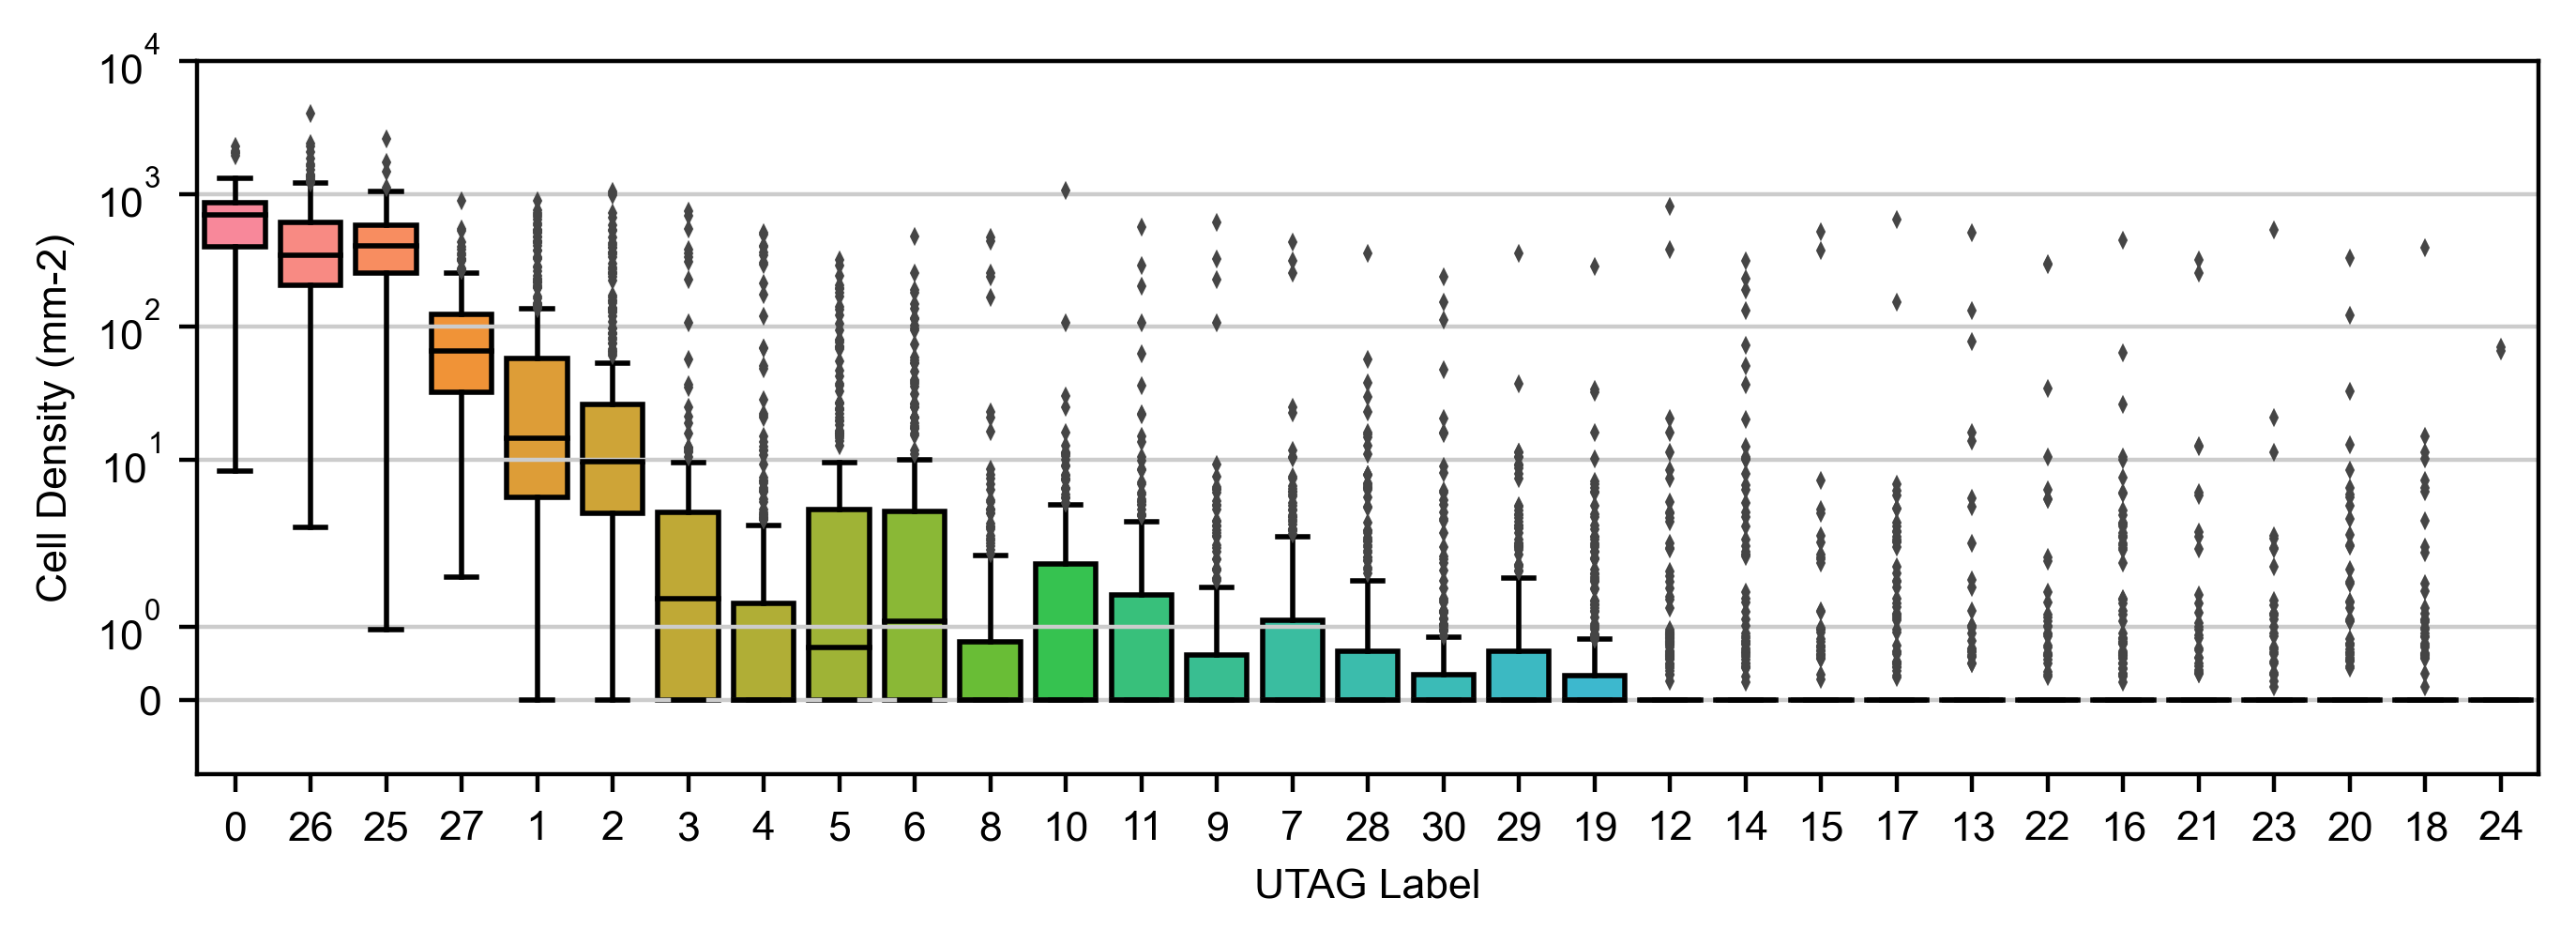

In [184]:
order = (
    pd.concat([roi_norm.mean(), roi_norm.quantile(0.75) > 0], axis = 1).sort_values([0.75, 0.00],ascending=False).index.tolist()
)
box_data = (
    roi_norm
    .stack()
    .reset_index()
    .rename(columns={"level_1": "UTAG Label", 0: "Density"})
)
box_data["UTAG Label"] = pd.Categorical(box_data["UTAG Label"], categories=order)

plt.figure(figsize=(8, 2.5), dpi=200)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

ax = sns.boxplot(
    data=box_data,
    x="UTAG Label",
    y="Density",
    #showmeans=True,
    fliersize=1,
    linewidth=1,
    saturation=1,
)
ax.set_yscale("symlog")
ax.set_ylim(-1, 10000)
ax.set_ylabel("Cell Density (mm-2)")
for i, box in enumerate(ax.artists):
    box.set_edgecolor("black")
    # box.set_facecolor('white')

    for j in range(6 * i, 6 * (i + 1)):
        ax.lines[j].set_color("black")
plt.savefig("figures/BRCA_supplement_cell_density_threshold.pdf", bbox_inches = 'tight')

In [193]:
pval_dict = dict()
for i, m in enumerate(roi_norm.mean()[:-1]):
    pos = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] > roi_norm[i].quantile(2/3)].index)]
    neg = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] <= roi_norm[i].quantile(1/3)].index)]
    pval = lr_test(pos, neg)
    pval_dict[str(i)] = pval




pval_df = pd.DataFrame({"pval": pval_dict})
pval_df = pval_df.loc[pval_df.index.isin(roi_norm.loc[:,roi_norm.quantile(0.75) > 0].columns.astype(str))]

pval_df.loc["HR+HER2+",'pval'] = hrher_pval
pval_df.loc["HR+HER2-",'pval'] = hr_pval
pval_df.loc["HR-HER2+",'pval'] = her_pval
pval_df.loc["TripleNeg",'pval'] = tn_pval
pval_df.loc["Grade 1",'pval'] = g1_pval
pval_df.loc["Grade 2",'pval'] = g2_pval
pval_df.loc["Grade 3",'pval'] = g3_pval

import pingouin as pg

pval_df["pval_adj"] = pg.multicomp(pval_df["pval"].values, method="fdr_bh")[1]
pval_df = pval_df.sort_values("pval_adj")

In [190]:
pval_dict = dict()
for i, m in enumerate(roi_norm.mean()[:-1]):
    pos = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] > m].index)]
    neg = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] <= m].index)]
    pval = lr_test(pos, neg)
    pval_dict[str(i)] = pval


pval_df = pd.DataFrame({"pval": pval_dict})
pval_df = pval_df.loc[pval_df.index.isin(roi_norm.loc[:,roi_norm.quantile(0.75) > 0].columns.astype(str))]

pval_df.loc["HR+HER2+",'pval'] = hrher_pval
pval_df.loc["HR+HER2-",'pval'] = hr_pval
pval_df.loc["HR-HER2+",'pval'] = her_pval
pval_df.loc["TripleNeg",'pval'] = tn_pval
pval_df.loc["Grade 1",'pval'] = g1_pval
pval_df.loc["Grade 2",'pval'] = g2_pval
pval_df.loc["Grade 3",'pval'] = g3_pval

import pingouin as pg

pval_df["pval_adj"] = pg.multicomp(pval_df["pval"].values, method="fdr_bh")[1]
pval_df = pval_df.sort_values("pval_adj")

In [194]:
pval_df.sort_values("pval_adj")

,pval,pval_adj
Grade 3,0.000007,0.000167
HR+HER2-,0.001459,0.018239
Grade 1,0.003704,0.025449
TripleNeg,0.004072,0.025449
25,0.007253,0.036264
8,0.008725,0.036354
27,0.013500,0.048215
10,0.023202,0.072506
2,0.033682,0.092363
Grade 2,0.036945,0.092363


C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C1B5174700> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C1B53D26D0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C12F4FE280> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\jkim0\anaconda3\envs\utag\lib\site-packages\pandas\plotting\_matplotlib\c

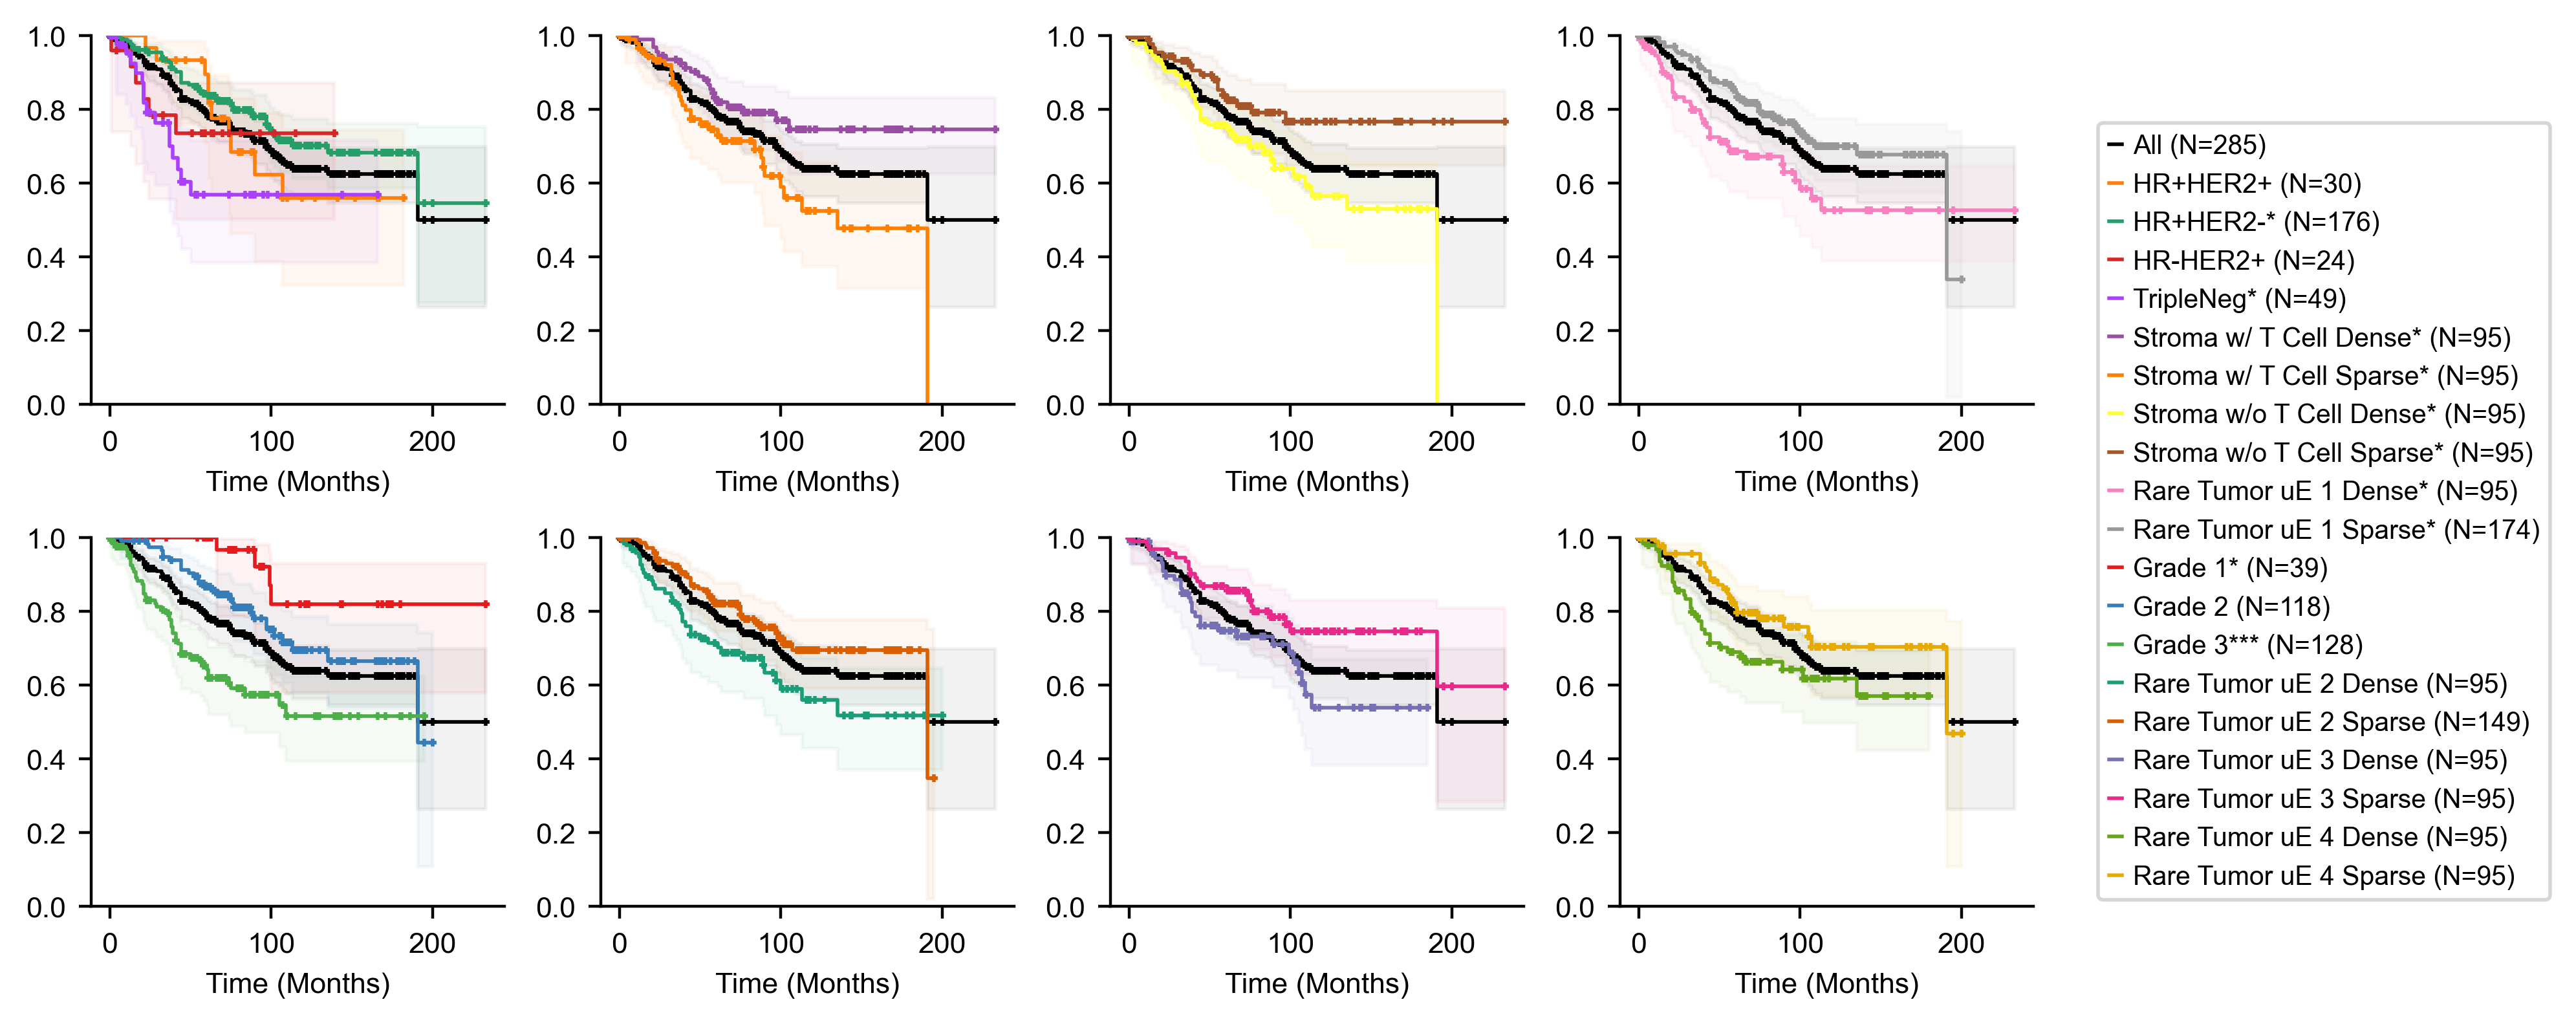

In [183]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4), dpi=200)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

kmf = kmf_fit(adata.obs, label="All")
kmf.plot_survival_function(
    ax=axs[0][0],
    ci_alpha=0.05,
    color="black",
    show_censors=True,
    censor_styles=censor_styles,
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["HR+HER2+", "pval_adj"])
kmf = kmf_fit(hrher, label=f"HR+HER2+{pval_star}")
kmf.plot_survival_function(
    ax=axs[0][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["HR+HER2-", "pval_adj"])
kmf = kmf_fit(hr, label=f"HR+HER2-{pval_star}")
kmf.plot_survival_function(
    ax=axs[0][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["HR-HER2+", "pval_adj"])
kmf = kmf_fit(her, label=f"HR-HER2+{pval_star}")
kmf.plot_survival_function(
    ax=axs[0][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["TripleNeg", "pval_adj"])
kmf = kmf_fit(tn, label=f"TripleNeg{pval_star}")
kmf.plot_survival_function(
    ax=axs[0][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    linewidth=1,
)

axs[0][0].legend(loc="lower left")
axs[0][0].set_xlabel("Timeline (Months)")


kmf = kmf_fit(adata.obs, label="All", legend=False)
kmf.plot_survival_function(
    ax=axs[1][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    color="black",
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["Grade 1", "pval_adj"])
kmf = kmf_fit(grade1, label=f"Grade 1{pval_star}")
kmf.plot_survival_function(
    ax=axs[1][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    color=colors[0],
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["Grade 2", "pval_adj"])
kmf = kmf_fit(grade2, label=f"Grade 2{pval_star}")
kmf.plot_survival_function(
    ax=axs[1][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    color=colors[1],
    linewidth=1,
)

pval_star = pval2star(pval_df.loc["Grade 3", "pval_adj"])
kmf = kmf_fit(grade3, label=f"Grade 3{pval_star}")
kmf.plot_survival_function(
    ax=axs[1][0],
    ci_alpha=0.05,
    show_censors=True,
    censor_styles=censor_styles,
    color=colors[2],
    linewidth=1,
)
axs[1][0].legend(loc="lower left")
axs[1][0].set_xlabel("Timeline (Months)")

uE_map = {
    25: "Stroma w/ T Cell",
    27: "Stroma w/o T Cell",
    8: "Rare Tumor uE 1",
    10: "Rare Tumor uE 2",
    2: "Rare Tumor uE 3",
    3: "Rare Tumor uE 4",
}

l = 3
for i_, i in enumerate(uE_map.keys()):
    m = roi_norm[i].mean()
    #pos = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] > ].index)]
    #neg = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] =< m].index)]
    pos = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] > roi_norm[i].quantile(2/3)].index)]
    neg = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i] <= roi_norm[i].quantile(1/3)].index)]
    # print(pos)
    j = int(i_ / 3)
    k = i_ % 3 + 1

    kmf = kmf_fit(adata.obs, label="All", legend=False)
    kmf.plot_survival_function(
        ax=axs[j][k],
        ci_alpha=0.05,
        show_censors=True,
        censor_styles=censor_styles,
        color="black",
        linewidth=1,
    )

    star_pos = pval2star(pval_df.loc[str(i), "pval_adj"])
    star_neg = star_pos
    """
    pval_pos = lr_test(pos, adata.obs)
    pval_neg = lr_test(neg, adata.obs)
    
    star_pos = pval2star(pval_pos)
    star_neg = pval2star(pval_neg)
    """
    kmf = kmf_fit(pos, label=f"{uE_map[i]} Dense{star_pos}")
    kmf.plot_survival_function(
        ax=axs[j][k],
        ci_alpha=0.05,
        show_censors=True,
        censor_styles=censor_styles,
        color=colors[3 + 2 * i_],
        linewidth=1,
    )

    kmf = kmf_fit(neg, label=f"{uE_map[i]} Sparse{star_neg}")
    kmf.plot_survival_function(
        ax=axs[j][k],
        ci_alpha=0.05,
        show_censors=True,
        censor_styles=censor_styles,
        color=colors[4 + 2 * i_],
        linewidth=1,
    )
    axs[j][k].legend(loc="lower left")
    axs[j][k].set_xlabel("Timeline (Months)")

pval_dict = dict()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for ax in fig.axes:
    ax.get_legend().remove()
    ax.set_ylim(0,1)
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time (Months)')
fig.legend(lines, labels, bbox_to_anchor=(1.01, 0.5), loc="center left")


plt.tight_layout()
plt.savefig("figures/BRCA_survival.pdf", bbox_inches="tight")
plt.show()

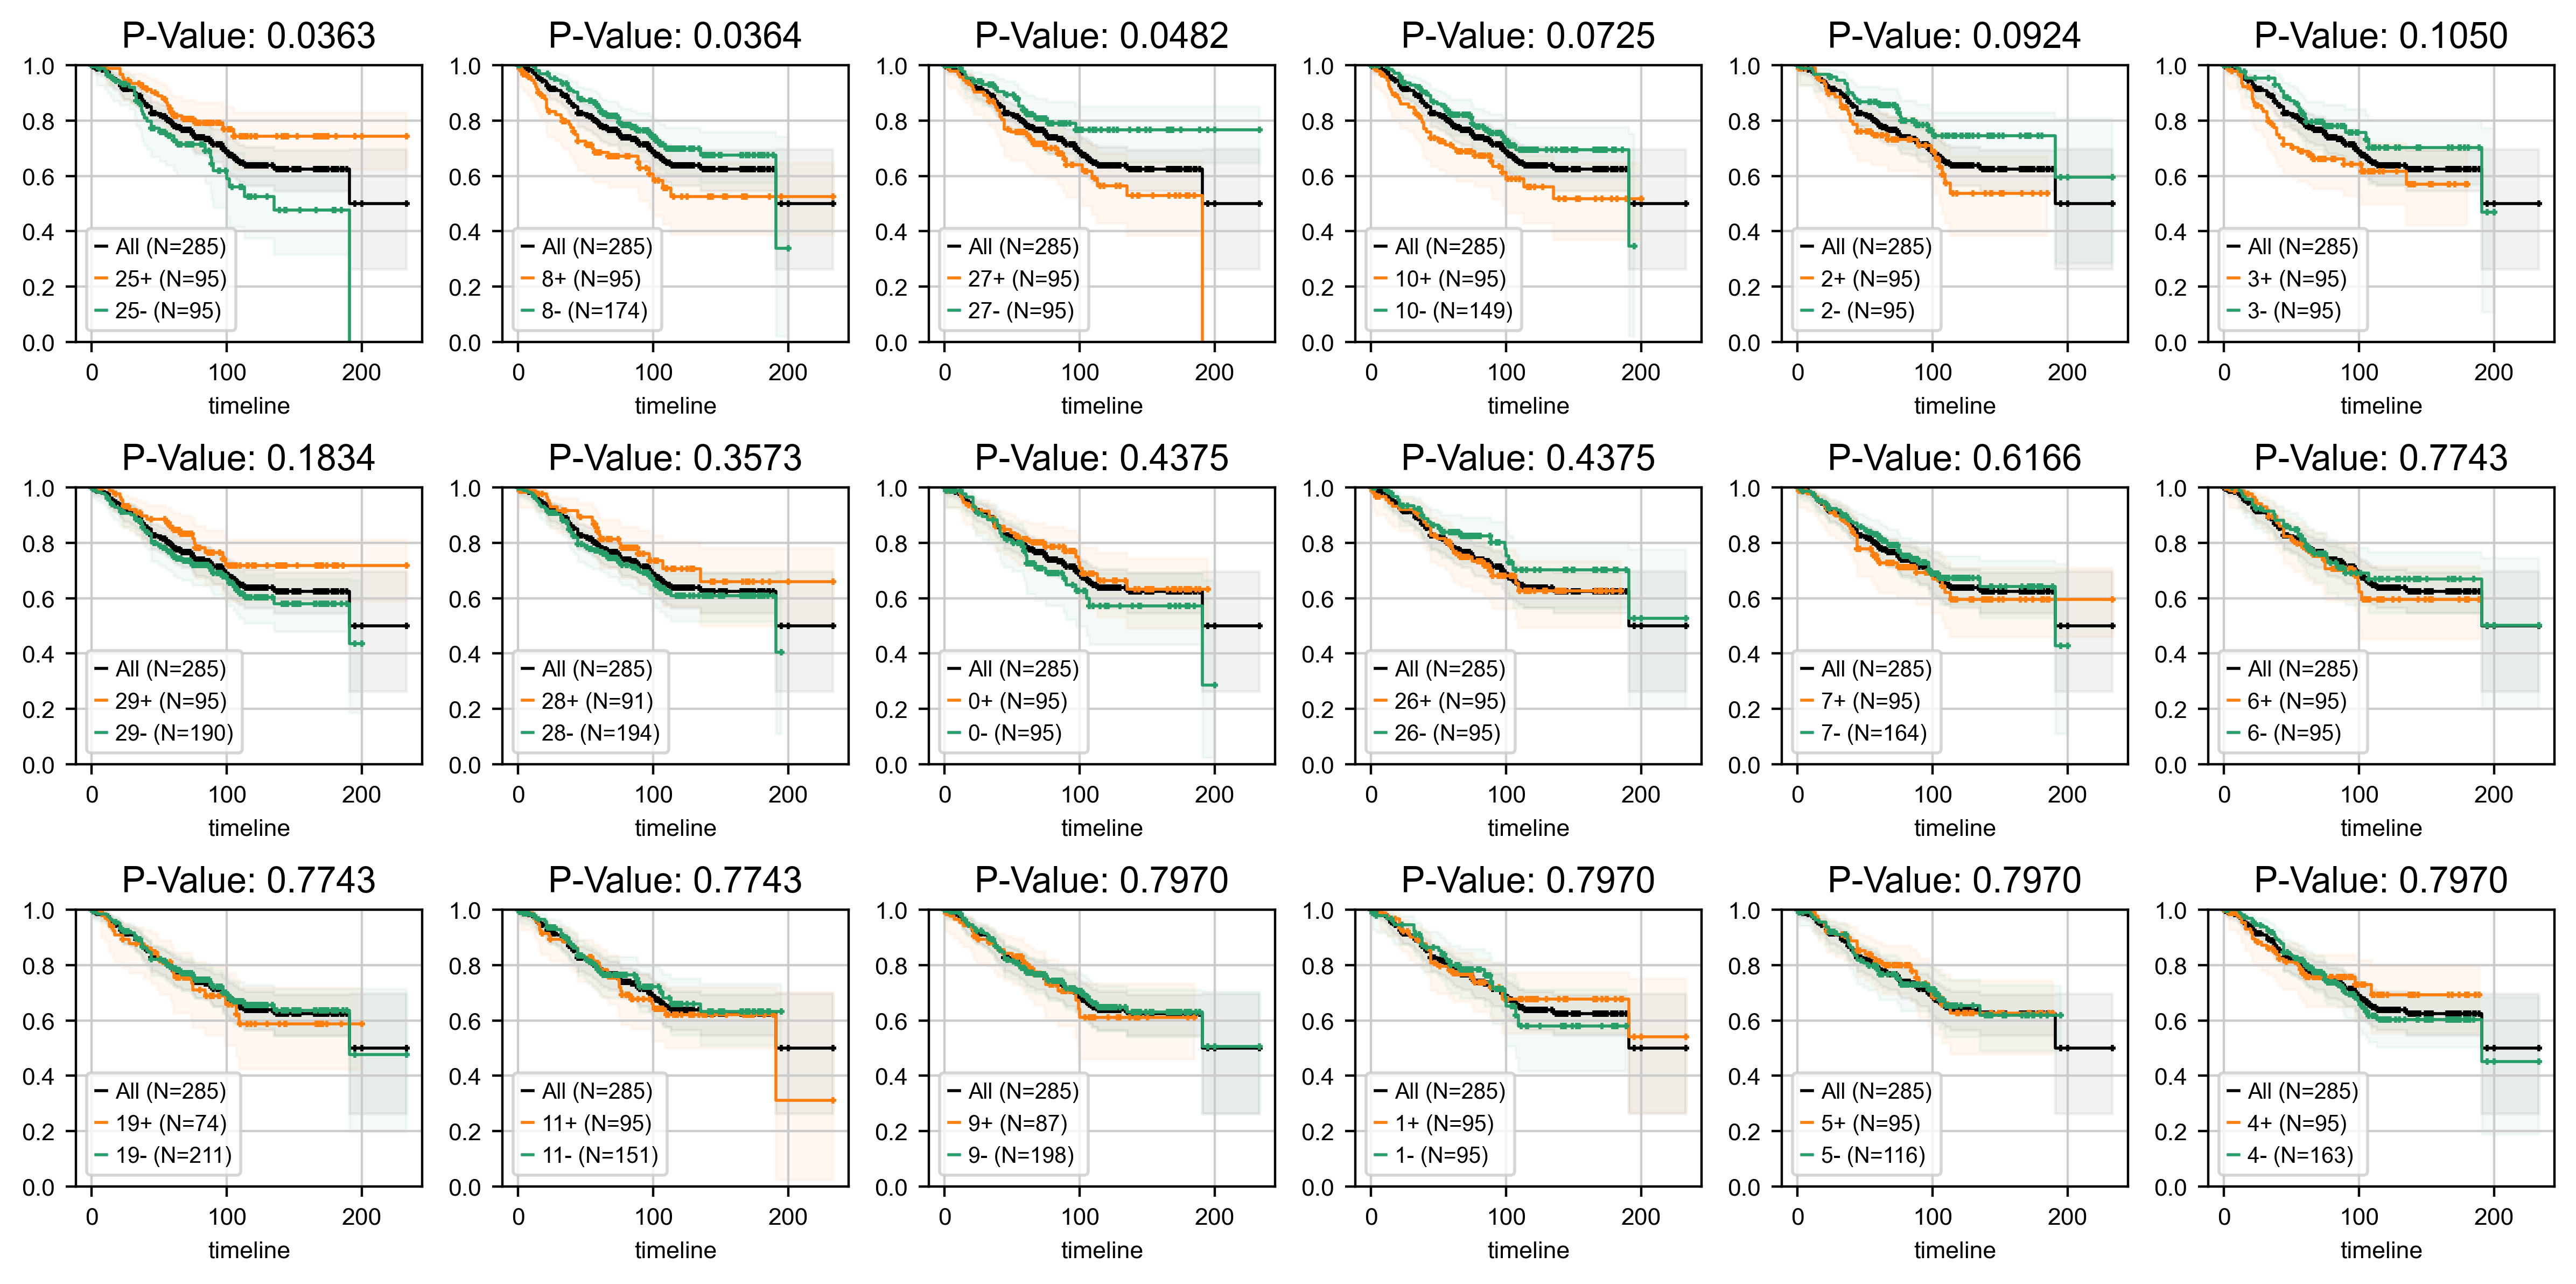

In [196]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, axs = plt.subplots(3, 6, figsize=(12, 6), dpi=200)

censor_styles = {"ms": 2}

pval_df = pval_df.sort_values("pval_adj")

for i, x in enumerate(
    pval_df.loc[
        ~pval_df.index.isin(
            [
                "HR+HER2+",
                "HR+HER2-",
                "HR-HER2+",
                "TripleNeg",
                "Grade 1",
                "Grade 2",
                "Grade 3",
            ]
        ),
        :,
    ].itertuples()
):

    i_ = int(x[0])

    pval = x[2]
    m = roi_norm[i_].mean()

    j = int(i / 6)
    k = i % 6
    pos = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i_] > roi_norm[i_].quantile(2/3)].index)]
    neg = adata.obs[adata.obs["PID"].isin(roi_norm[roi_norm[i_] <= roi_norm[i_].quantile(1/3)].index)]
    # print(pos)
    kmf = kmf_fit(adata.obs, label="All")
    kmf.plot_survival_function(
        ax=axs[j][k],
        ci_alpha=0.05,
        color="black",
        legend=False,
        show_censors=True,
        censor_styles=censor_styles,
        linewidth=1,
    )

    kmf = kmf_fit(pos, label=f"{i_}+")
    kmf.plot_survival_function(
        ax=axs[j][k],
        ci_alpha=0.05,
        show_censors=True,
        censor_styles=censor_styles,
        linewidth=1,
    )

    kmf = kmf_fit(neg, label=f"{i_}-")
    kmf.plot_survival_function(
        ax=axs[j][k],
        ci_alpha=0.05,
        show_censors=True,
        censor_styles=censor_styles,
        linewidth=1,
    )

    # if pval < 0.10:
    #    print(pval)
    axs[j][k].set_title("P-Value: {:.4f}".format(pval), fontsize=12)
    axs[j][k].legend(loc="lower left")
    
    axs[j][k].set_ylim(0,1)
    

plt.tight_layout()
plt.savefig("figures/BRCA_survival_supplement.pdf")

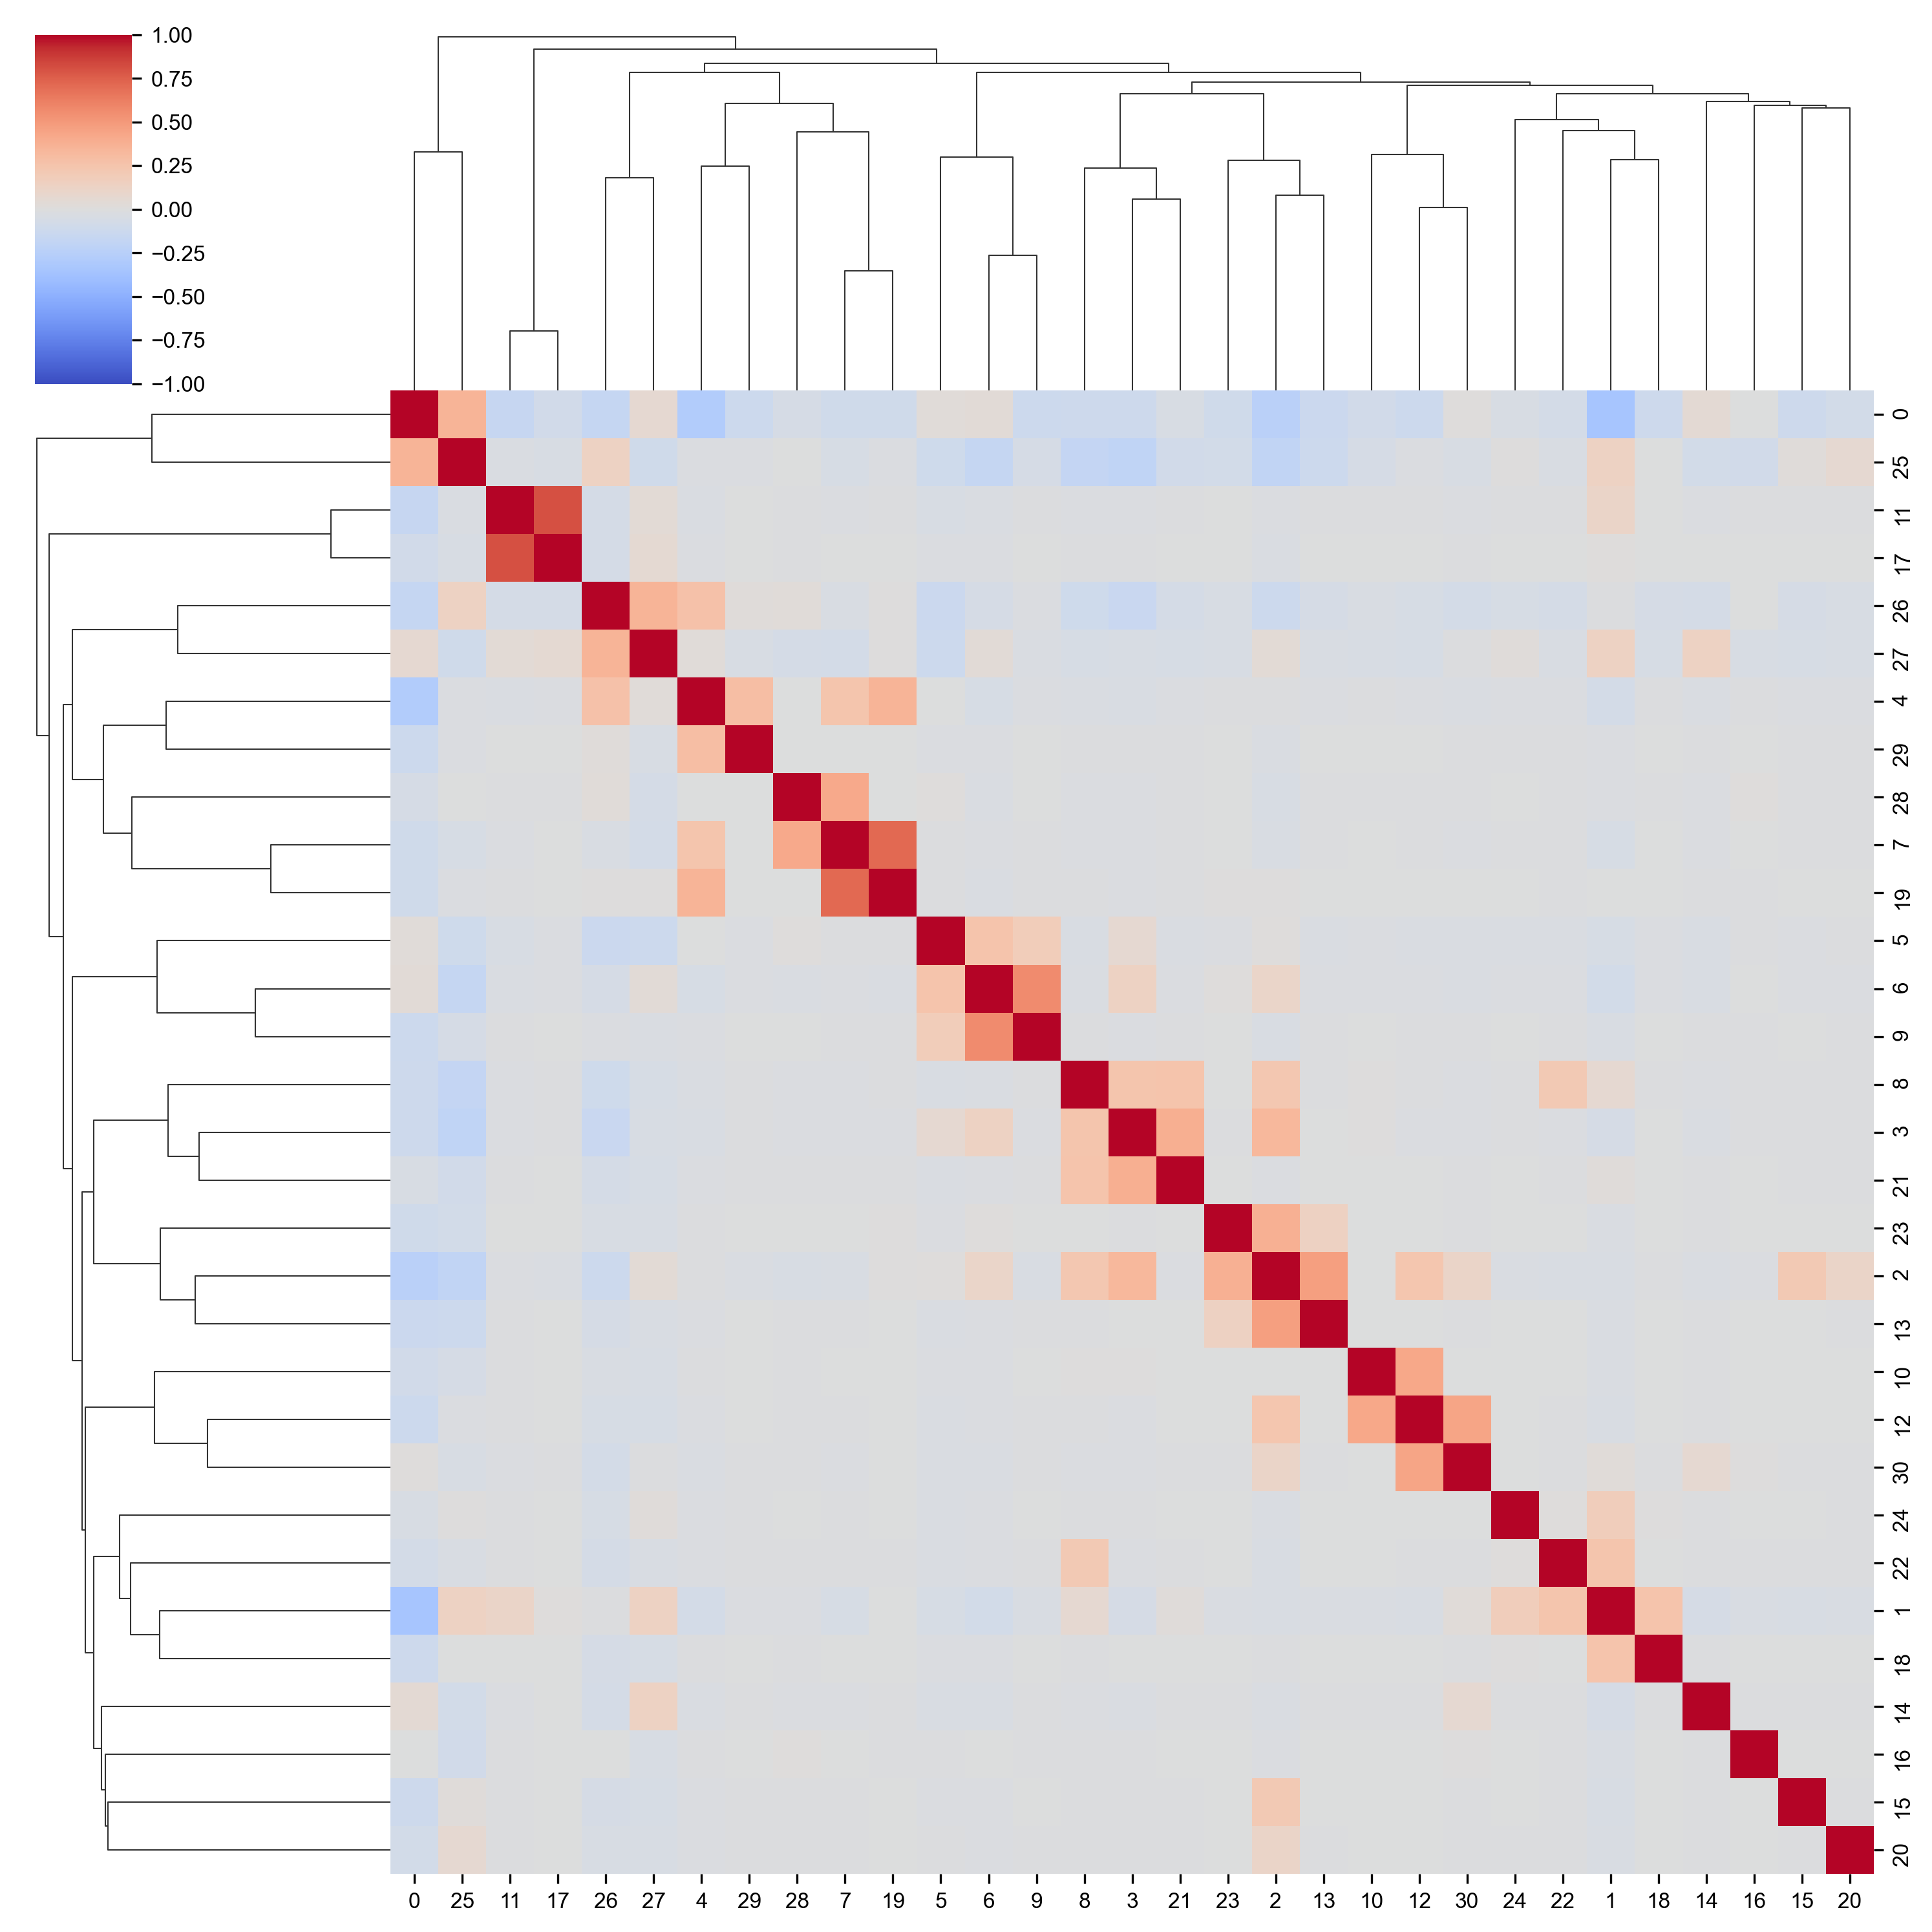

In [200]:
sns.clustermap(roi_norm.corr(), cmap = 'coolwarm', vmax = 1, vmin = -1)

In [207]:
roi_norm

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
PID,,,,,,,,,,,,,,,,,,,,,
1,1021.301881,1.318660,19.120565,1.318660,0.000000,1.318660,9.889947,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,294.720427,298.676405,150.986527,0.000000,0.000000,0.000000
2,613.985571,54.607611,2.800390,2.800390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.700098,0.000000,0.0,0.0,696.597084,349.348688,22.403122,7.701073,0.700098,0.000000
3,477.300716,263.246634,22.601984,7.977171,2.659057,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.329528,0.0,0.0,642.162245,486.607415,45.203968,1.329528,1.329528,1.329528
4,563.004277,6.336845,97.489918,5.849395,0.000000,0.487450,0.487450,0.487450,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,422.131345,322.691629,69.217842,0.000000,0.000000,0.000000
5,219.705008,14.380691,8.788200,0.000000,20.772110,0.798927,0.000000,0.798927,0.000000,3.195709,...,0.000000,0.000000,0.0,0.0,415.442197,1004.251619,107.855186,0.798927,3.195709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,437.343953,14.501806,238.134927,9.159036,1.526506,0.000000,1.526506,0.763253,0.763253,0.000000,...,0.000000,0.000000,0.0,0.0,279.350588,398.418051,134.332523,0.000000,3.053012,0.000000
282,1308.013967,5.060015,0.843336,2.530008,0.000000,2.530008,115.537017,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,430.101304,181.317217,15.180046,0.000000,0.000000,0.000000
283,1070.901271,16.747370,2.791228,0.930409,3.721638,0.000000,0.000000,0.930409,0.000000,0.930409,...,0.000000,0.000000,0.0,0.0,501.490691,564.758533,65.128661,0.000000,0.930409,0.930409


,OSmonth
PID,
239,128
141,180
72,186
18,118
114,104
...,...
110,13
3,23
65,130


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,OSmonth
PID,,,,,,,,,,,,,,,,,,,,,
1,1021.301881,1.318660,19.120565,1.318660,0.000000,1.318660,9.889947,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,294.720427,298.676405,150.986527,0.000000,0.000000,0.000000,33
2,613.985571,54.607611,2.800390,2.800390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,696.597084,349.348688,22.403122,7.701073,0.700098,0.000000,101
3,477.300716,263.246634,22.601984,7.977171,2.659057,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329528,0.0,0.0,642.162245,486.607415,45.203968,1.329528,1.329528,1.329528,23
4,563.004277,6.336845,97.489918,5.849395,0.000000,0.487450,0.487450,0.487450,0.000000,0.000000,...,0.000000,0.0,0.0,422.131345,322.691629,69.217842,0.000000,0.000000,0.000000,63
5,219.705008,14.380691,8.788200,0.000000,20.772110,0.798927,0.000000,0.798927,0.000000,3.195709,...,0.000000,0.0,0.0,415.442197,1004.251619,107.855186,0.798927,3.195709,0.000000,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,437.343953,14.501806,238.134927,9.159036,1.526506,0.000000,1.526506,0.763253,0.763253,0.000000,...,0.000000,0.0,0.0,279.350588,398.418051,134.332523,0.000000,3.053012,0.000000,41
282,1308.013967,5.060015,0.843336,2.530008,0.000000,2.530008,115.537017,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,430.101304,181.317217,15.180046,0.000000,0.000000,0.000000,144
283,1070.901271,16.747370,2.791228,0.930409,3.721638,0.000000,0.000000,0.930409,0.000000,0.930409,...,0.000000,0.0,0.0,501.490691,564.758533,65.128661,0.000000,0.930409,0.930409,141


311.91670933504497

[None, None]

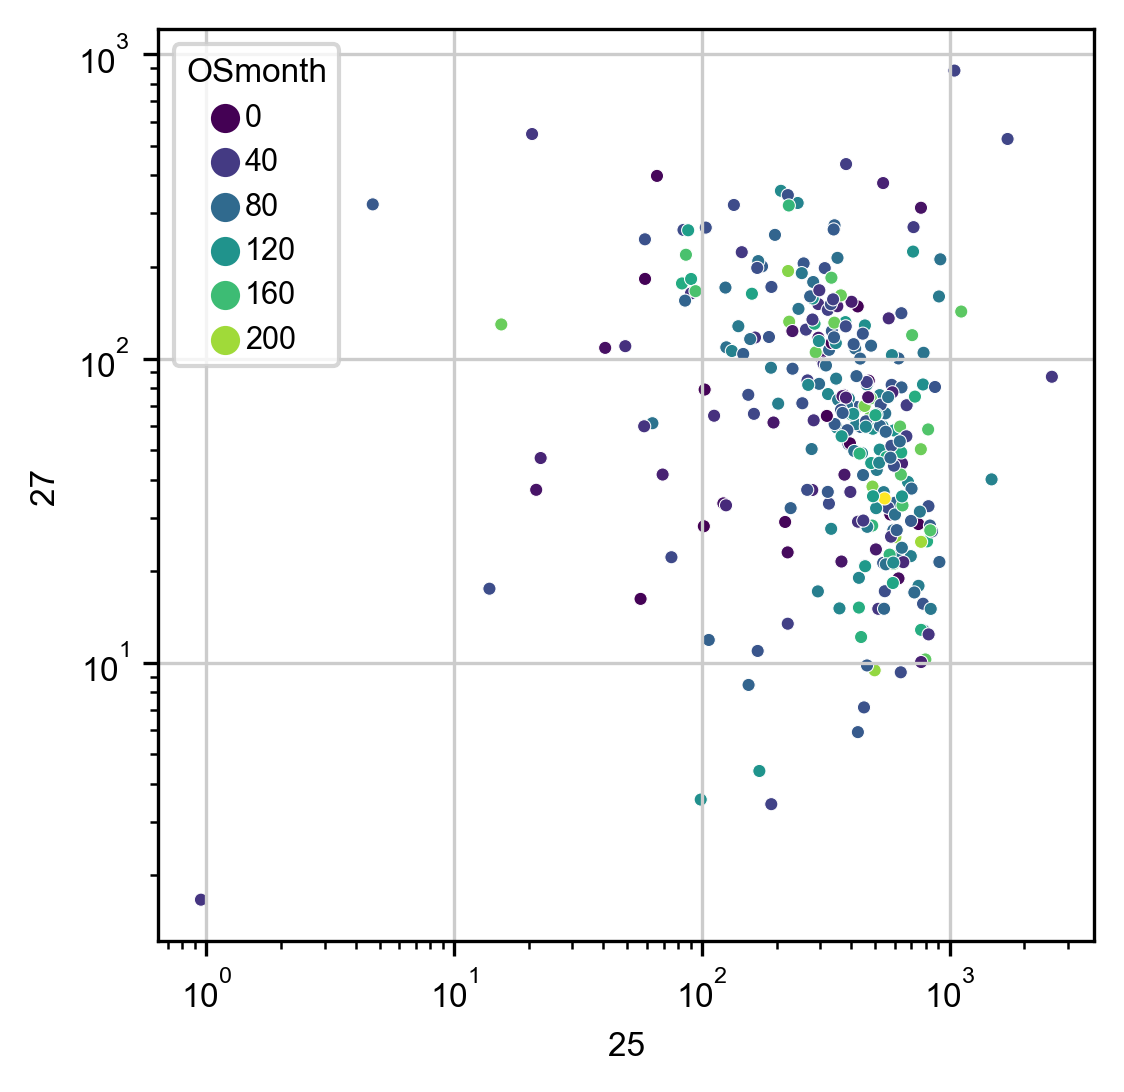

In [216]:
scatter_data = roi_norm.merge(adata.obs[['PID', 'OSmonth']].drop_duplicates().set_index('PID'), left_index = True, right_index = True)
ax = sns.scatterplot(data = scatter_data, x = 25, y = 27, s = 10, hue = 'OSmonth', palette = 'viridis')

ax.set(xscale="log", yscale = 'log')